In [3]:
import numpy as np
import random as rd
import matplotlib.pyplot as plt
from scipy.constants import k as bolt_cst

from numba import jit

In [56]:

def field(lista, n_spin):
    dim = int(np.sqrt(len(lista)))
    matrix = np.array(lista).reshape((dim, dim))

    n_spin -= 1
    # Calcula la fila y columna correspondientes al número del spin
    fila = n_spin // dim
    columna = n_spin % dim

    if fila == 0:
        nbr_down = matrix[fila + 1, columna]
        nbr_up = matrix[(fila - 1) % dim, columna]
        nbr_left = matrix[fila, columna - 1]
        if columna == dim - 1:
            nbr_right = matrix[fila, (columna + 1) % dim]
        else:
            nbr_right = matrix[fila, columna + 1]
    
    elif fila == dim-1:
        nbr_down = matrix[(fila + 1) % dim, columna]
        nbr_up = matrix[(fila - 1), columna]
        nbr_left = matrix[fila, columna - 1]
        if columna == dim - 1:
            nbr_right = matrix[fila, (columna + 1) % dim]
        else:
            nbr_right = matrix[fila, columna + 1]
            
    else:
        nbr_down = matrix[fila + 1, columna]
        nbr_up = matrix[(fila - 1), columna]
        nbr_left = matrix[fila, columna - 1]
        if columna == dim - 1:
            nbr_right = matrix[fila, (columna + 1) % dim]
        else:
            nbr_right = matrix[fila, columna + 1]
        
    h = nbr_down + nbr_right + nbr_left + nbr_up

    return h, nbr_up, nbr_down, nbr_left, nbr_right


def energy_ising(configuration):
    N = len(configuration)
    E = 0
    for i in range(1, N):
        h = field(configuration, i)[0]
        E -= configuration[i] * h

    return -np.int64(E/2)


### Markov-ising

In [52]:

def markov_ising(config, E, T):
    beta = 1/(T)
    k = rd.randint(1, len(config))
    h = field(config, k)[0]
    delta_E = 2*h*config[k-1]
    gamma = np.exp(-1*beta*delta_E)
    prob = rd.uniform(0, 1)
    if prob < gamma:
        E += delta_E
        config[k-1] *= -1
    else:
        E = energy_ising(config)
    return config, E

### 6x6

In [31]:
@jit
def measure_markov(config, T, trials):
    E = energy_ising(config)
    N = len(config)
    densities = [0 for _ in range(-2*N, 2*N + 4, 4)]
    energy_list = [int(i) for i in range(-2*N, 2*N + 4, 4)]
    counter = 0
    try:
        initial_index = energy_list.index(E)
        densities[initial_index] += 1
    except:
        pass
    j = 1
    while counter <= trials:
        config_new, E_new = markov_ising(config, E, T)
        
        if E_new in energy_list:
            E = E_new
            #print(E)
            config = config_new
            if counter == 500*j:
                indice = energy_list.index(E)
                densities[indice] += 1
                j += 1
            if counter == int(trials/4):
                print("al 25")
            counter += 1
    
        else:
            pass
    
    return energy_list, densities


In [32]:
@jit
def thermo_ising(densities, energies, T):
    Z = 0
    N = len(energies)-1
    beta = 1/T
    expected_E = 0
    expected_E2 = 0
    for i, E in enumerate(energies):
        E_prime = E 
        Z += densities[i]*np.exp(-beta*E_prime)
        expected_E += E_prime*densities[i]*np.exp(-beta*E_prime)
        expected_E2 += E_prime**2 *densities[i]*np.exp(-beta*E_prime)
        
    expected_E 
    expected_E2 
    
    cv = beta**2 * (expected_E2 - expected_E**2)/N
    e_dens = (expected_E )/N

    return e_dens, cv

In [6]:
random_config = lambda x: rd.choice([1, -1])
config = [random_config(x) for x in range(16)]
trials = 10**4

In [7]:
temps = np.arange(0.5, 10, 0.5)
cv = []
e_dens = []
for T in temps:
    energies, densities = measure_markov(config, T, trials)
    result = thermo_ising(densities, energies, T)
    if T == 5.0:
        print("temp 5")
    e_dens.append(result[0])
    cv.append(result[1])


c:\Users\vicex\AppData\Local\Programs\Python\Python39\lib\site-packages\awkward\_cpu_kernels.py:9: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


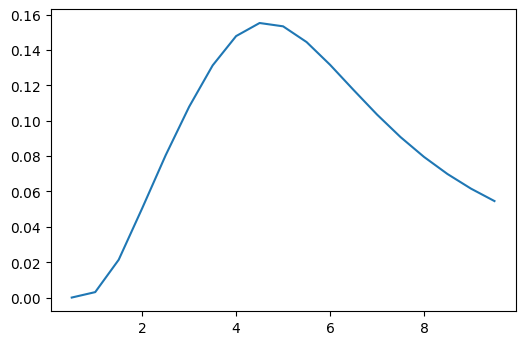

In [88]:
fig, ax = plt.subplots(1, 1, dpi=100)
ax.plot(temps, np.array(cv))

### Markov_ising con magnetización

In [62]:

def measure_magnet(config, T, trials):
    E = energy_ising(config)
    N = len(config)
    
    energy_list = [int(i) for i in range(-2*N, 2*N + 4, 4)]
    magn_list = [int(i) for i in range(-N, N, 2)]
    fila = len(energy_list)
    columna = len(magn_list)

    dens_EM = np.zeros((fila,columna), dtype=np.int64)

    counter = 0
    try:
        E_init_index = energy_list.index(E)
        M_init = np.sum(np.array(config))
        M_init_index = magn_list.index(M_init)
        dens_EM[E_init_index][M_init_index] += 1
    except:
        pass
    j = 1
    while counter <= trials:
        config_new, E_new = markov_ising(config, E, T)
        
        if E_new in energy_list:
            E = E_new
            #print(E)
            config = config_new

            M = np.sum(np.array(config))
            if M in magn_list:

                if counter == 100*j:
                    try:
                        
                        index_m = magn_list.index(M)
                        index_e = energy_list.index(E)
                        dens_EM[index_e][index_m] += 1
                        j += 1
                    except:
                        print("falló", index_e, index_m)
                        print(M)
                counter += 1
    
        else:
            pass
    return dens_EM, energy_list, magn_list

In [50]:

def thermo_magnet(densities, energies, magnets, T):
    Z = 0
    N = len(densities[0])//2
    beta = 1/T
    expected_M = 0
    
    for i, E in enumerate(energies):
        E_prime = E - np.min(energies)
        for j, M in enumerate(magnets):
            Z += densities[i][j]*np.exp(-beta*E_prime)
            expected_M += densities[i][j]*M*np.exp(-beta*E_prime)

    expected_M /= Z

    return np.abs(expected_M)

In [110]:
def measure_magnet2(config, T, trials):
    E = energy_ising(config)
    N = len(config)
    
    energy_list = [int(i) for i in range(-2*N, 2*N + 4, 4)]
    magn_list = [int(i) for i in range(-N, N, 2)]
    fila = len(energy_list)
    columna = len(magn_list)

    dens_EM = np.zeros((fila,columna), dtype=np.int64)
    magnetization_values = []

    counter = 0
    try:
        E_init_index = energy_list.index(E)
        M_init = np.sum(np.array(config))
        M_init_index = magn_list.index(M_init)
        dens_EM[E_init_index][M_init_index] += 1
    except:
        pass
    j = 1
    while counter <= trials:
        config_new, E_new = markov_ising(config, E, T)
        
        if E_new in energy_list:
            E = E_new
            #print(E)
            config = config_new

            M = np.sum(np.array(config))
            if M in magn_list:
                if counter == 100*j:
                    try:
                        magnetization_values.append(M)
                        index_m = magn_list.index(M)
                        index_e = energy_list.index(E)
                        dens_EM[index_e][index_m] += 1
                        j += 1
                    except:
                        print("falló", index_e, index_m)
                        print(M)
                counter += 1
    
        else:
            pass

    abs_magn = np.abs(magnetization_values)
    return dens_EM, energy_list, magn_list, np.mean(abs_magn)

In [111]:
random_config_magn = lambda x: rd.choice([1, -1])
config_magn = np.array([random_config_magn(x) for x in range(16)])
trials = 10**4
temps = np.arange(1.5, 5, 0.1)
N = 16
MvT_4x4 = []
for T in temps:
    dens_EM, energies, magnets, mean = measure_magnet2(config_magn, T, trials)
    
    #data_magn = thermo_magnet(dens_EM, energies, magnets, T)

    
    MvT_4x4.append(mean)

In [116]:
random_config_magn = lambda x: rd.choice([1, -1])
config_magn = np.array([random_config_magn(x) for x in range(64)])
trials = 10**4
temps = np.arange(1.5, 5, 0.1)
N = 64
MvT_8x8 = []
for T in temps:
    dens_EM, energies, magnets, mean = measure_magnet2(config_magn, T, trials)
    
    #data_magn = thermo_magnet(dens_EM, energies, magnets, T)

    
    MvT_8x8.append(mean)

In [120]:
random_config_magn = lambda x: rd.choice([1, -1])
config_magn = np.array([random_config_magn(x) for x in range(16**2)])
trials = 10**4
temps = np.arange(1.5, 5, 0.1)
N = 16**2
MvT_16 = []
for T in temps:
    dens_EM, energies, magnets, mean = measure_magnet2(config_magn, T, trials)
    
    #data_magn = thermo_magnet(dens_EM, energies, magnets, T)

    
    MvT_16.append(mean)

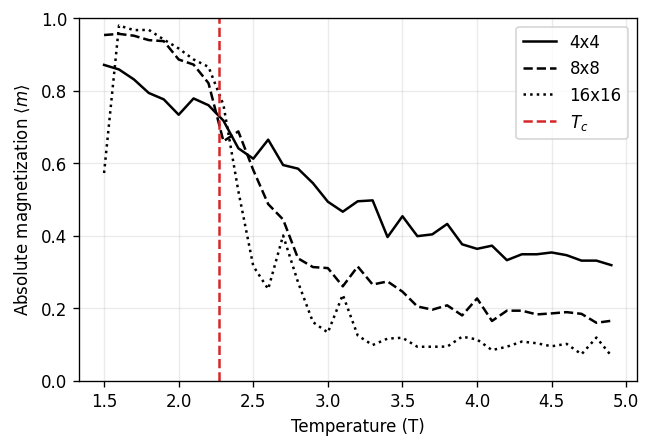

In [125]:
fig, ax = plt.subplots(1, 1, dpi=120)
N_4x4 = 16
N_8x8 = 64
N_16x16 = 16**2
ax.plot(np.array(temps), np.array(MvT_4x4)/N_4x4, label="4x4", ls="solid", color="k")
ax.plot(np.array(temps), np.array(MvT_8x8)/N_8x8, label="8x8", ls="dashed", color="k")
ax.plot(np.array(temps), np.array(MvT_16)/N_16x16, label="16x16", ls="dotted", color="k")
ax.set_ylim(0, 1)

ax.grid(alpha=0.25)
ax.set_xlabel("Temperature (T)")
ax.set_ylabel(r"Absolute magnetization $\langle m \rangle$")
ax.vlines(2.269, 0, 1, ls="dashed", color="tab:red", label=r"$T_c$")
ax.legend()